# Evaluation Task

## Import Extracted Data

In [1]:
# create a directory to store the plots
import os
save_dir = "FinalPlots"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

dataset_path = "/home/jason/AutoEncoder/extracted_input.csv"

dataset = pd.read_csv(dataset_path)

In [3]:
dataset.head()

,E,pt,eta,phi
0,258722.0,243675.0,0.328962,2.25014
1,520092.0,108590.0,-2.247300,-1.85679
2,383024.0,88405.6,2.145160,-1.95635
3,39507.6,35365.1,0.470460,-1.16445
4,225430.0,26878.2,-2.816080,-2.25938


## Split Data
Train and test set are obtained from the dataset in a ratio of 80:20

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset.copy(), test_size=0.2, random_state=45)

# indices are reset so that reassigning values of boxcox transformation works
index = pd.Series([i for i in range(0, len(test))])
test = test.set_index(index)

index = pd.Series([i for i in range(0, len(train))])
train = train.set_index(index)

### Plot the Input data
UnNormalised data is plotted

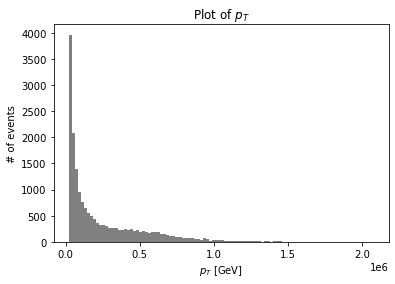

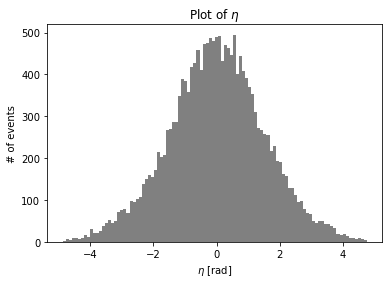

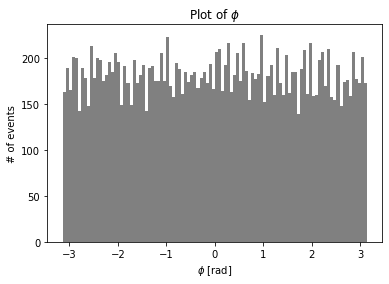

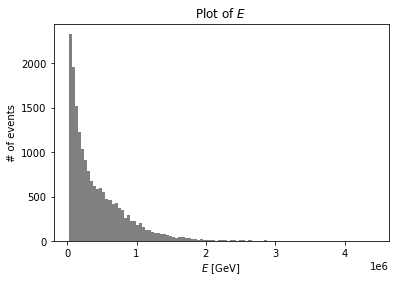

In [5]:
import matplotlib.pyplot as plt

unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

branches=["pt","eta","phi","E"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    plt.title("Plot of " + variable_list[kk])
    plt.savefig(os.path.join(save_dir, "UnNormalised_"+branches[kk]),dpi=300)
    plt.show()

## Custom Normalisation
We normalise the data and I noticed boxcox seems to work better than log10 for "E" and "pt"

In [6]:
# We normalise eta and pi such that their range is between (-1, 1)
train["eta"] = train["eta"]/5
train["phi"] = train["phi"]/3

test["eta"] = test["eta"]/5
test["phi"] = test["phi"]/3

# since data is right skewed, boxcox transformation works best
# we first apply the transformation to the train and then apply it to the
#    test dataset so that we dont leak information about the test data
normalised_pt, maxlog_pt = stats.boxcox(train["pt"].to_numpy(dtype=np.float64))
normalised_E, maxlog_E = stats.boxcox(train["E"].to_numpy(dtype=np.float64))

normalised_E = normalised_E/10

normalised_pt_mean = normalised_pt.mean()
normalised_E_mean = normalised_E.mean()

train["pt"] = pd.DataFrame(normalised_pt-normalised_pt_mean)
train["E"] = pd.DataFrame(normalised_E-normalised_E_mean)

normalised_pt_test = stats.boxcox(test["pt"].to_numpy(dtype=np.float64), maxlog_pt)
normalised_E_test = stats.boxcox(test["E"].to_numpy(dtype=np.float64), maxlog_E)/10
    
test["pt"] = pd.DataFrame(normalised_pt_test-normalised_pt_mean)
test["E"] = pd.DataFrame(normalised_E_test-normalised_E_mean)

    
train.head()

,E,pt,eta,phi
0,0.112126,-0.112356,0.429768,0.056841
1,0.210463,0.275786,0.212474,0.904687
2,0.277597,0.411763,0.124140,0.966567
3,0.374858,-0.493136,0.784006,0.921080
4,0.238748,0.297086,0.213176,-0.954223


## Plotting Normalised data

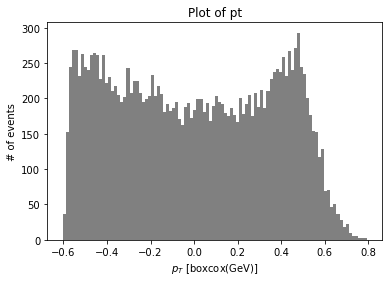

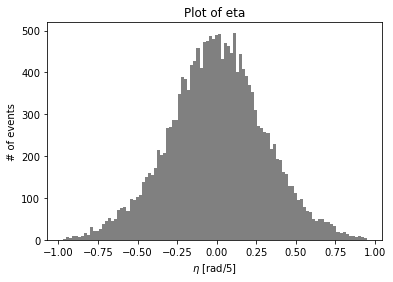

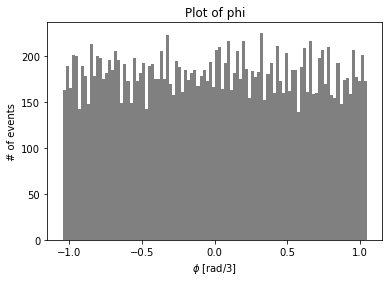

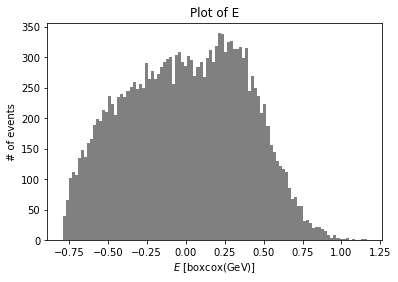

In [7]:
import matplotlib.pyplot as plt

unit_list = ['[boxcox(GeV)]', '[rad/5]', '[rad/3]', '[boxcox(GeV)]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

branches=["pt","eta","phi","E"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    plt.title("Plot of " + branches[kk])
    plt.savefig(os.path.join(save_dir, "Normalised_"+branches[kk]),dpi=300)
    plt.show()

## Loading data into Pytorch Dataloader

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

# creating a copy of the data for X and y
# X and y are the same since the model is an autoencoder
X_test, y_test = test.copy(), test.copy()
X_train, y_train = train.copy(), train.copy()

print(train)

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(y_train.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(X_test.values, dtype=torch.float), torch.tensor(y_test.values, dtype=torch.float))

              E        pt       eta       phi
0      0.112126 -0.112356  0.429768  0.056841
1      0.210463  0.275786  0.212474  0.904687
2      0.277597  0.411763  0.124140  0.966567
3      0.374858 -0.493136  0.784006  0.921080
4      0.238748  0.297086  0.213176 -0.954223
...         ...       ...       ...       ...
18123  0.398207  0.478393 -0.144510 -0.459873
18124  0.612202 -0.223689  0.746482 -0.604360
18125  0.305874  0.381490  0.178883 -0.056376
18126  0.145595 -0.021625 -0.390404  0.488260
18127  0.364775  0.403387 -0.200444  0.445960

[18128 rows x 4 columns]


/home/jason/miniconda3/envs/AE-compression/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378062065/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:

bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

## Creating a Tanh model with Batch Normalisation after each layer
It was seen that Tanh varient with a low MSE and low mean residual reconstruction error

In [10]:
# We choose this architecture as it worked best with the amount of data we had resulting in a lower loss
class AE_3D_200_Tanh(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_Tanh, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 100)
        self.en3 = nn.Linear(100, 50)
        self.en4 = nn.Linear(50, 3)
        self.de1 = nn.Linear(3, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200, n_features)
        self.Acti = nn.Tanh()

    def encode(self, x):
        x = self.en1(x)
        x = self.Acti(x)
        x = self.en2(x)
        x = self.Acti(x)
        x = self.en3(x)
        x = self.Acti(x)
        return self.en4(x)

    def decode(self, x):
        x = self.Acti(x)
        x = self.de1(x)
        x = self.Acti(x)
        x = self.de2(x)
        x = self.Acti(x)
        x = self.de3(x)
        x = self.Acti(x)
        return self.de4(x)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01) 
    
model = AE_3D_200_Tanh()
model.to('cpu')
#model.apply(init_weights)

AE_3D_200_Tanh(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (Acti): Tanh()
)

In [11]:
from fastai.metrics import mse
from fastai.callback.tracker import EarlyStoppingCallback
loss_func = nn.MSELoss()

wd = 1e-6
recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=[recorder])

## 1cycle training
The 1cycle policy allows to us train the model very quickly, a phenomenon termed superconvergence.

Learning rate with the minimum loss: 0.0033113110810518267
Learning rate with the steepest gradient: 0.0063095735386013985


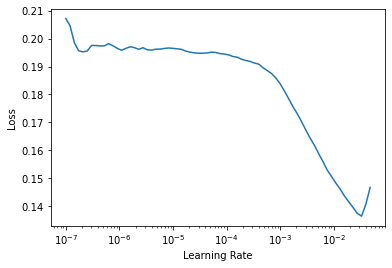

In [12]:
from fastai.callback import schedule

# to use 1cycle callback from fastai we need to find the optimum learning rate which we can find using lr_finder()
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [13]:
import time

# we find the time needed for training
start = time.perf_counter() # Starts timer
learn.fit_one_cycle(60, lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

epoch,train_loss,valid_loss,time
0,0.102840,0.043325,00:00
0,0.102840,0.043325,00:00
1,0.036983,0.013641,00:00
1,0.036983,0.013641,00:00
2,0.016671,0.009758,00:00
2,0.016671,0.009758,00:00
3,0.010761,0.008291,00:00
3,0.010761,0.008291,00:00
4,0.007106,0.003294,00:00
4,0.007106,0.003294,00:00


Training took 43.940875150001375 seconds


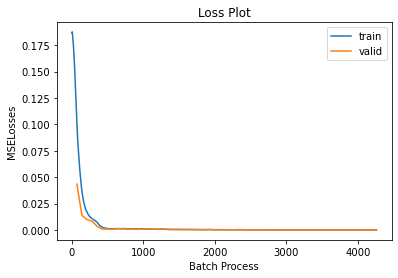

In [14]:
# Loss of train and valid is plotted against Number of batches processed

recorder.plot_loss()
plt.title("Loss Plot")
plt.xlabel("Batch Process")
plt.ylabel("MSELosses")
plt.savefig(os.path.join(save_dir, 'Loss Plot.png'))


In [15]:
learn.validate()

(#1) [4.021879249194171e-06]

## Plots

In [16]:
from scipy.special import inv_boxcox
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['pt'] = inv_boxcox(df['pt']+normalised_pt_mean, maxlog_pt)
    df['E'] = inv_boxcox((df['E']+normalised_E_mean)*10, maxlog_E)
    return df

### Plot of Reconstruted input vs Orignal Input

Output of the model on the test data is obtained and then it is unnormalised.

R2 of  E 0.9997441057523315
R2 of  pt 0.9998639821092496
R2 of  eta 0.9999602187150897
R2 of  phi 0.9999955982325336


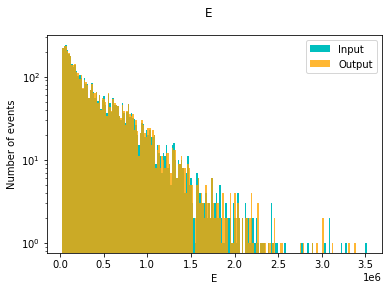

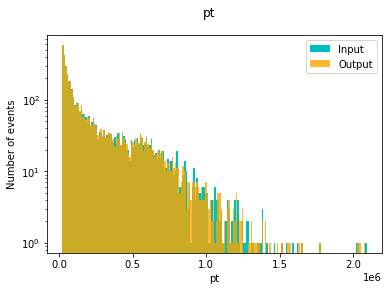

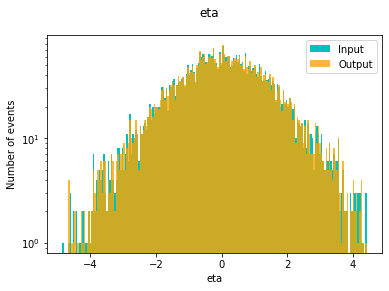

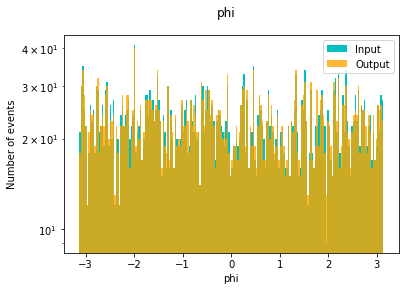

In [17]:
from sklearn.metrics import r2_score

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = False # Option to save figure

# Histograms
idxs = (0, len(test))  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = custom_unnormalize(pd.DataFrame(data, columns=test.columns))
pred_df = custom_unnormalize(pd.DataFrame(pred, columns=test.columns))

unnormalized_data_df = data_df
unnormalized_pred_df = pred_df    
    
alph = 0.8
n_bins = 200

# Plots of Input vs Reconstructed Input is being plotted here.
for kk in np.arange(4):
    plt.figure()
    # R2 score of each variable is being printed
    print("R2 of ", test.columns[kk], r2_score(unnormalized_data_df[test.columns[kk]], unnormalized_pred_df[test.columns[kk]]))
    n_hist_data, bin_edges, _ = plt.hist(unnormalized_data_df[test.columns[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(unnormalized_pred_df[test.columns[kk]], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'___TanhNoInit.png'))
    plt.legend()

### Plot of Residuals
Residuals are computed then the Mean and Standard deviation of residuals along with their errors are computed and plotted

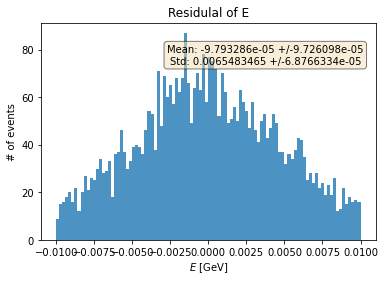

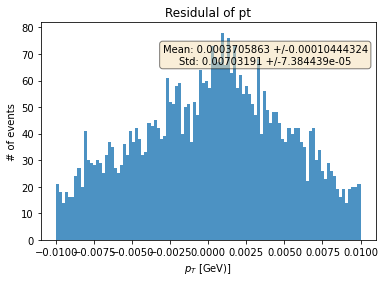

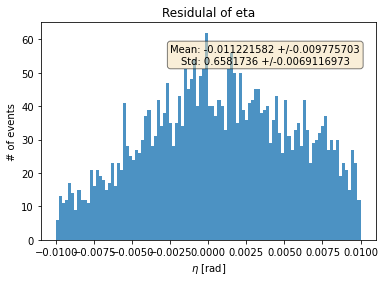

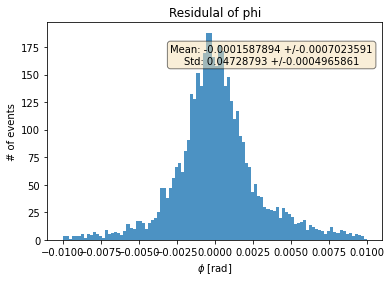

In [18]:
from scipy import stats

def find_diff(pred, data):
    diff = (pred-data)
    for i in test.columns:
        diff[i] = diff[i]/data[i]
    return diff

# Residual is being computed from the input and the output of the model (reconstructed input)
diff = find_diff(unnormalized_pred_df, unnormalized_data_df)

# we find the mean and Standard devation of the residual
mean = diff.mean()
mean_diff = stats.sem(diff)
std = diff.std()
std_error = diff.std(ddof=0) / np.sqrt(2*len(diff))

unit_list = ['[GeV]', '[GeV)]', '[rad]', '[rad]']
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']

branches=["E", "pt","eta","phi"]

n_bins = 100

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

for kk in range(0,4):
    _, ax = plt.subplots()
    n_hist_data, bin_edges, _ = plt.hist(diff[branches[kk]], label='Input', alpha=0.8, bins=100, range=(-0.01, 0.01))
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    plt.title('Residulal of '+ branches[kk])
    ax.text(0.67, 0.85, "Mean: "+str(mean[kk])+" +/-"+str(mean_diff[kk])+"\nStd: "+str(std[kk]) + " +/-"+str(std_error[kk]), horizontalalignment='center',
      verticalalignment='center', transform=ax.transAxes, bbox=props)
    plt.savefig(os.path.join(save_dir,"Resuidal of "+branches[kk]+'___TanhNoInit.png'))
    plt.show()

In [19]:
diff.head()

,E,pt,eta,phi
0,0.005248,0.000789,-0.013040,0.002705
1,0.001987,-0.003521,-0.005015,0.016201
2,0.003780,-0.000704,-0.017604,-0.003953
3,0.006825,-0.004799,0.011606,0.011116
4,-0.003151,0.003360,0.006921,-0.000540


### Corelation of Residuals
Correlation matrix for the residuals is computed and plotted, it can be seen that the model recongnises the Correlation between E and Pt

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix for the residuals
corr = diff.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})